In [1]:
import tensorflow as tf
import tensorflow.keras

In [2]:
import numpy as np
import pandas as pd
import json
import nltk

In [3]:
import matplotlib.pyplot as plt

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalAveragePooling1D, Flatten

Intents

In [5]:
from tensorflow.keras.models import Model

In [6]:
%%writefile content.json
{
  "intents": [
    {
      "tag": "greeting",
      "input": ["hello", "hi there", "nice to meet you", "hi", "hey there"],
      "responses": [
        "hi,Welcome to the private gpt",
        "Hey, how can i help you ?",
        "Hi, this is your assistant, what do you want ? "
      ]
    },
    {
      "tag": "goodbye",
      "input": ["thank you", "have a good day", "goodbye", "bye", "thanks"],
      "responses": [
        "Okay,Bye",
        "Have a nice day",
        "Adios",
        "Goodbye",
        "See you later",
        "Nice Conversation, bye",
        "Take care",
        "We'll meet soon"
      ]
    },
    {
      "tag": "howami",
      "input": ["how are you ?", "I am fine, how are you ?", "are you fine ?", "how are things going on ?", "everyting okay ?"],
      "responses": [
        "Yeah, am fine",
        "Everything's going on well",
        "Doing good. Thanks you are my best friend",
        "Things are Great",
        "Yeah fine, nothing much goong on in my life",
        "I am great, wanna join the pirate's organisation ?",
        "Everything's great",
        "I am doing good. Life is boring. need to go on an adventure"
      ]
    },
    {
      "tag": "weather",
      "input": ["what's the weather like?", "how's the weather today?", "is it raining outside?", "what's the temperature?"],
      "responses": [
        "The weather is cloudy",
        "It's currently X degrees Celsius.",
        "You might need an umbrella today."
      ]
    },
    {
      "tag": "time",
      "input": ["What time is it?", "Do you know the time?", "Can you tell me the current time?", "What's the time now?", "What's the time?"],
      "responses": [
        "It's currently HH:MM.",
        "The time is now HH:MM AM/PM.",
        "It's HH hours and MM minutes."
      ]
    },
    {
      "tag": "joke",
      "input": ["Tell me a joke.", "Do you know any jokes?", "I could use a laugh."],
      "responses": [
        " What did the spider do on the computer? : Made a website!",
        "Why was the computer cold?: It left it's Windows open!"
      ]
    },
    {
      "tag": "news",
      "input": ["What's happening in the world?", "Any interesting news?", "Tell me about the latest news."],
      "responses": [
        "General elections are being held in India from 19 April to 1 June 2024 in seven phases, to elect 543 members of the Lok Sabha.",
        "There's been a recent development in Y.",
        "The headlines today include Z."
      ]
    },
    {
      "tag": "fact",
      "input": ["tell me a random fact", "give me an interesting fact", "tell me a fact", "can you share a fun fact?"],
      "responses": [
        "Niagara Falls never freezes.",
        "Here's an interesting fact: 92% of the worlds currency is digital.",
        "Owls dont have eyeballs."
      ]
    }
  ]
}


Overwriting content.json


In [7]:
with open('content.json') as content:
    data1 = json.load(content)

In [8]:
#getting all the data to lists
tags = []
inputs = []
responses = {}

for intent in data1['intents']:
    responses[intent['tag']] = intent['responses']
    for line in intent['input']:
        inputs.append(line)
        tags.append(intent['tag'])


In [9]:
#converting to dataframe
data = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

In [10]:
#printing the data
data

,inputs,tags
0,hello,greeting
1,hi there,greeting
2,nice to meet you,greeting
3,hi,greeting
4,hey there,greeting
5,thank you,goodbye
6,have a good day,goodbye
7,goodbye,goodbye
8,bye,goodbye
9,thanks,goodbye


In [11]:
#removing punctuations
import string
data['inputs'] = data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs'] = data['inputs'].apply(lambda wrd:''.join(wrd))
data

,inputs,tags
0,hello,greeting
1,hi there,greeting
2,nice to meet you,greeting
3,hi,greeting
4,hey there,greeting
5,thank you,goodbye
6,have a good day,goodbye
7,goodbye,goodbye
8,bye,goodbye
9,thanks,goodbye


In [12]:
#tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['inputs'])
train = tokenizer.texts_to_sequences(data['inputs'])
#apply padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

#encoding the outputs
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

In [13]:
input_shape = x_train.shape[1]
print(input_shape)

7


In [14]:
vocabulary = len(tokenizer.word_index)
print("number of unique words: ",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words:  65
output length:  8


In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Flatten, Dense

# Define output length (number of classes or categories)
output_length = 100

# Example vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Define input shape
input_shape = 7  # Example input shape for sequences of length 100

# Input layer
inputs = Input(shape=(input_shape,), name='input')

# Embedding layer
embedding = Embedding(vocab_size, 100, input_length=input_shape, name='embedding')(inputs)

# LSTM layer
lstm = LSTM(128, name='lstm')(embedding)

# Flatten layer
flatten = Flatten(name='flatten')(lstm)

# Dense layer for classification
outputs = Dense(output_length, activation="softmax", name='output')(lstm)

# Create model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 7, 100)         │         6,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,748 (534.17 KB)

 Trainable params: 136,748 (534.17 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
#compiling the model
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

**Training**

In [17]:
#training the model
history = model.fit(x_train, y_train, epochs=100, batch_size=8, validation_split=0.2)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.0819 - loss: 4.5992 - val_accuracy: 0.0000e+00 - val_loss: 4.6006
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4824 - loss: 4.5356 - val_accuracy: 0.0000e+00 - val_loss: 4.6005
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4231 - loss: 4.4316 - val_accuracy: 0.0000e+00 - val_loss: 4.6001
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3958 - loss: 4.1908 - val_accuracy: 0.0000e+00 - val_loss: 4.6113
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2662 - loss: 3.5307 - val_accuracy: 0.0000e+00 - val_loss: 4.8206
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2157 - loss: 2.3843 - val_accuracy: 0.0000e+00 - val_loss: 6.2198
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2306 - loss: 1.8871 - val_accuracy: 0.0000e+00 - val_loss: 7.7580
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3102 - loss: 1.7918 - val

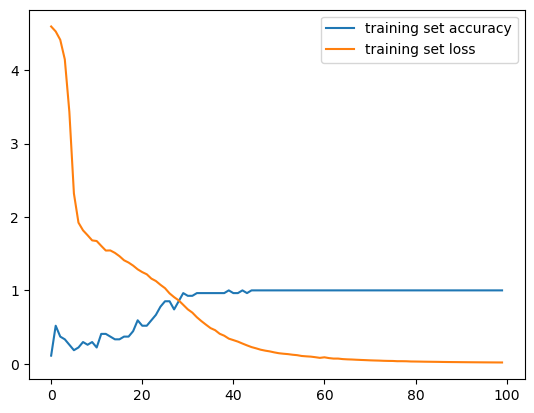

In [18]:
# Plotting model accuracy and loss
plt.plot(history.history['accuracy'], label='training set accuracy')
plt.plot(history.history['loss'], label='training set loss')
plt.legend()
plt.show()

**Testing**

In [19]:
 #chatting
import random

while True:
    prediction_input = input('You: ')

    # Tokenizing and padding the input
    prediction_input = tokenizer.texts_to_sequences([prediction_input])
    prediction_input = pad_sequences(prediction_input, maxlen=input_shape)

    # Getting the prediction from the model
    output = model.predict(prediction_input)
    predicted_tag_index = output.argmax(axis=1)[0]
    predicted_tag = le.inverse_transform([predicted_tag_index])[0]

    # Selecting a random response from the responses associated with the predicted tag
    responses_for_predicted_tag = [intent['responses'] for intent in data1['intents'] if intent['tag'] == predicted_tag]
    response = random.choice(responses_for_predicted_tag[0])

    print("Chatbot:", response)

    if predicted_tag == "goodbye":
        break



You: thanks
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
Chatbot: We'll meet soon


In [20]:
!pip install PyPDF2

Defaulting to user installation because normal site-packages is not writeable


In [21]:
!pip install openai==0.28

Defaulting to user installation because normal site-packages is not writeable


In [22]:
pip install langchain

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import tkinter as tk
from tkinter import scrolledtext, filedialog
import openai

# Set your OpenAI API key
openai.api_key = "sk-proj-lABSvZO7zFwDsWp1ajzTT3BlbkFJ8M3rdJB8mkmWwQxjMkGZ"

# Function to generate a response from the chatbot model
def generate_response():
    user_input = user_input_text.get("1.0", tk.END).strip()

    # Tokenizing and padding the input
    input_sequence = tokenizer.texts_to_sequences([user_input])
    input_sequence = pad_sequences(input_sequence, maxlen=input_shape)

    # Getting the prediction from the model
    output = model.predict(input_sequence)
    predicted_tag_index = output.argmax(axis=1)[0]
    predicted_tag = le.inverse_transform([predicted_tag_index])[0]

    # Selecting a random response from the responses associated with the predicted tag
    responses_for_predicted_tag = [intent['responses'] for intent in data1['intents'] if intent['tag'] == predicted_tag]
    response = random.choice(responses_for_predicted_tag[0])

    # Displaying the response in the chat window with improved styling
    chat_window_text.insert(tk.END, "You: " + user_input + "\n", "user")
    chat_window_text.insert(tk.END, "Chatbot: " + response + "\n\n", "bot")

    # Auto-scroll to the bottom
    chat_window_text.see(tk.END)

def upload_pdf():
    file_path = filedialog.askopenfilename(filetypes=[("PDF files", "*.pdf")])
    if file_path:
        print("File uploaded successfully:", file_path)
        process_pdf(file_path)
    else:
        print("No file selected.")

def process_pdf(file_path):
    try:
        # Read PDF content
        with open(file_path, "rb") as file:
            pdf_content = file.read()

        # Process PDF content using OpenAI API
        response = openai.Completion.create(
            engine="text-davinci-003",  # Choose appropriate OpenAI engine
            prompt=pdf_content.decode("latin-1"),  # Convert binary content to string using Latin-1 encoding
            max_tokens=1000,  # Adjust as needed
            temperature=0.7  # Adjust as needed
        )

        # Extract response text
        completion_text = response.choices[0].text

        # Display response in GUI
        chat_window_text.insert(tk.END, "PDF Content:\n" + completion_text + "\n\n", "pdf")

    except Exception as e:
        # Handle errors
        chat_window_text.insert(tk.END, f"Error processing PDF: {e}\n", "error")
      

# Create main window
root = tk.Tk()
root.title("Chatbot GUI")
root.geometry("500x400")

# Styling
root.configure(background="#f0f0f0")

# Create chat window
chat_window_text = scrolledtext.ScrolledText(root, wrap=tk.WORD, width=50, height=20, bg="#ffffff", fg="#333333", font=("Helvetica", 12))
chat_window_text.grid(row=0, column=0, padx=10, pady=10, columnspan=2)

# Create user input area
user_input_text = tk.Text(root, wrap=tk.WORD, width=50, height=3, bg="#ffffff", fg="#333333", font=("Helvetica", 12))
user_input_text.grid(row=1, column=0, padx=10, pady=10)

# Create send button
send_button = tk.Button(root, text="Send", command=generate_response, bg="#0080ff", fg="#ffffff", font=("Helvetica", 12))
send_button.grid(row=1, column=1, padx=10, pady=10)

# Create file upload button
upload_button = tk.Button(root, text="Upload PDF", command=upload_pdf, bg="#0080ff", fg="#ffffff", font=("Helvetica", 12))
upload_button.grid(row=2, column=0, padx=10, pady=10)

# Add tags for styling
chat_window_text.tag_config("user", foreground="green")
chat_window_text.tag_config("bot", foreground="blue")
chat_window_text.tag_config("pdf", foreground="purple")
chat_window_text.tag_config("error", foreground="red")

# Start the GUI event loop
root.mainloop()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


In [ ]:
root = tk.Tk()
root.title('PDF Question and Answer App')
openai.api_key = "sk-proj-lABSvZO7zFwDsWp1ajzTT3BlbkFJ8M3rdJB8mkmWwQxjMkGZ"


def upload_pdf():
    file_path = filedialog.askopenfilename(filetypes=[('PDF files', '*.pdf')])
    if file_path:
        pdf_reader = PdfReader(file_path)
        texts = ""
        for page in pdf_reader.pages:
            texts += page.extract_text()
        
        # Split text
        text_splitter = CharacterTextSplitter(chunk_size=1000, separator="\n", chunk_overlap=0)
        
        # Add all texts into a smaller chunks
        chunks = text_splitter.split_text(texts)
        
         # Create embeddings for chunks
        embeddings = openai.api_key
        doc_search = FAISS.from_texts(chunks, embeddings)
        
        def execute_query():
            query = query_entry.get()
            if query:
                # Code to search for similar documents and retrieve the answer
                docs_new = doc_search.similarity_search(query)
                llm = OpenAI(temperature=0)
                chain = load_qa_chain(llm, chain_type="stuff")
                answer = chain.run(input_documents=docs_new, question=query)
                answer_text.configure(text="Answer:\n" + answer)
        
        query_label = tk.Label(root, text="Enter a query:")
        query_label.pack()
        
        query_entry = tk.Entry(root, width=50, font=("Arial", 14))
        query_entry.pack(pady=10)
        
        execute_button = tk.Button(root, text="Execute", command=execute_query)
        execute_button.pack()
        
        answer_text = tk.Label(root, text="", font=("Arial", 16), wraplength=600, justify="left")
        answer_text.pack(pady=20)
    
browse_button = tk.Button(root, text="Upload your PDF", command=upload_pdf)
browse_button.pack(pady=20)

# Start the Tkinter event loop
root.mainloop()